<a href="https://colab.research.google.com/github/Veronika2311/DL_for_NLP_course2021/blob/main/Homework1Part1_Ganeeva_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашняя работа №1 Part1
Вам предстоит:

Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен



In [76]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28Х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что то обучится :(  
  

Торч - объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов. В целом не стоит здесь долго думать

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им полльзоваться, пока оставляем эз из.


In [78]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [79]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются бачами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете что такое итерируемый объект, погуглите :) можно думать об этом как о списке с составными элементами (элемент - батч - набор примеров) 

In [80]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [81]:
X, y = next(iter(train_loader)) #next(iter(x) - Возвращает следующий элемент итератора.
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [82]:
y

tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, то есть первый батч имееет правильную размерность.В y - 1 это класс цифры "7", 0 - "3"

In [83]:
X.shape #128 - примеров, [1, 28, 28] - размерность картинки, 1 - значит что из трех каналов (Р, Г, Б) у нас всего один, а сама картинка 28 на 28

torch.Size([128, 1, 28, 28])

In [84]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки

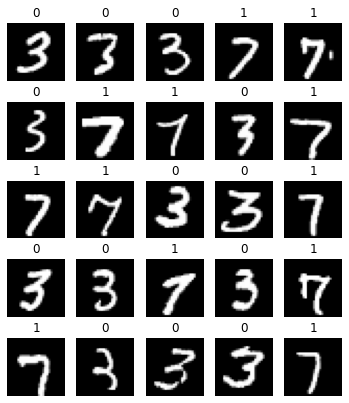

In [85]:
X, y = next(iter(train_loader))
X = X.numpy() # перевод тензора в массив нумпай, просто изменение типа данных 
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем боле мы знаем что значение каждого пикселя независимо друг друга.

In [86]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [87]:
y

tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0])

Такой У нам не совсем подходит. Сейчас объясню почему. Размерность Х (128,784) матрично перемножим на скрытый слой (784,1) и получится (128,1). Нужно понимать, что размерность (128,) и (128,1) это немного разные вещи  

In [88]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [90]:
#pred

Теперь у нас есть предсказания и их размерность (128,1). Нужно будет счтить лосс с у, поэтому приведем его к такой же размерности с expand_dims - это функция есть в нумпае, также есть и в торче

In [91]:
y = np.expand_dims(y, 1)

In [92]:
#y

Итерация по эпохам

In [18]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Однослойный персептрон

In [93]:
learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

w1 = np.random.rand(n_feat,1)*0.01 #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе, 
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0
b1 = np.zeros(1) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)

        h1 = x.dot(w1) + b1 #переход в одномерное пространство
        p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
        
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        #расчет энтропии с усреднением по размеру бача
          
        losses.append(bce) 
        #ниже производная bce и sigmoid, если вы распишите две этих производные, перемножите и сократите, то полчится следующая строчка
        dp = (p - y) / batch_size
        dw1 = np.dot(x.T, dp) # производная по линейному преобразванию, относительно W - весов 
        db1 = np.sum(dp) # производная по лин преобразованиюб относительно В - баяса, 
        #здесь по идее должно быть перемножение на единичный вектор (128,1), но это тоже самое что и сумма значениеб типа лайф хак
        
        w1 -= learning_rate * dw1 # Обновим веса и баясы 
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


А теперь построим график функции потерь

Text(0, 0.5, 'Loss function')

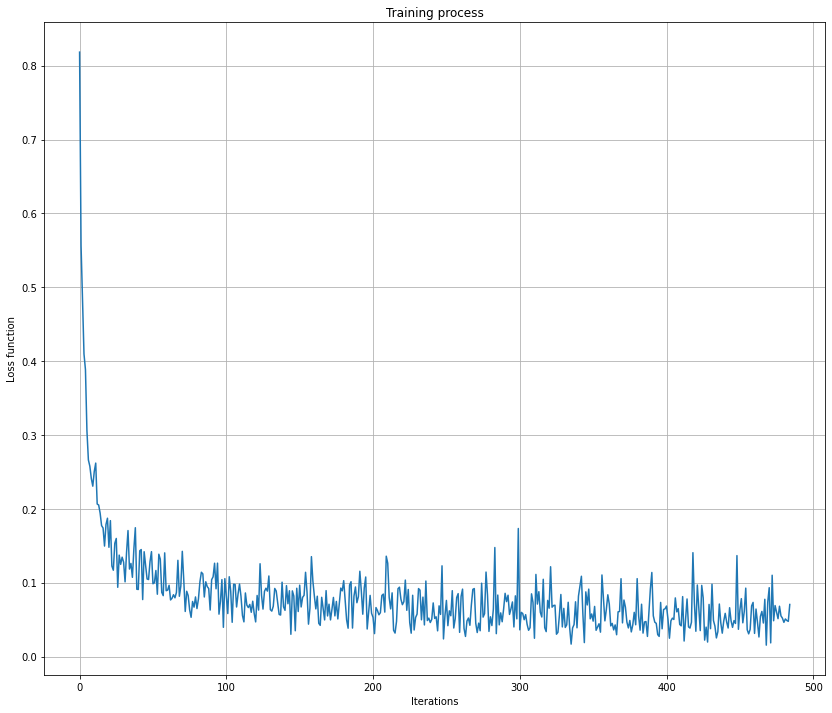

In [94]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

А теперь ваша очередь, нужно написать двуслоный персептрон, согласно коду и выкладкам выше

In [110]:
### КОД СЮДА ###

learning_rate = 0.01
epochs = 5
inner_features = 1

w1 = np.random.rand(n_feat,inner_features)*0.01
b1 = np.zeros(inner_features)
w2 = np.random.rand(inner_features, 1)*0.01
b2 = np.zeros(1)


losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)

        # forward
        h1 = x.dot(w1) + b1 
        p1 = 1/(1+np.exp(-h1))        

        h2 = p1.dot(w2) + b2
        p2 = 1/(1+np.exp(-h2))

        # рассчет bce
        bce = (-np.sum(np.multiply(np.log(p2), y) + np.multiply((1 - y), np.log(1 - p2)))) / batch_size
        losses.append(bce) 

        # backward        
        dp2 = (p2 - y)
        dw2 = np.dot(p1.T, dp2)
        db2 = np.sum(dp2)
        
        dp1 = np.dot(dp2, w2.T)
        dw1 = np.dot(x.T, dp1 * p1 * (1 - p1))
        db1 = np.sum(dp1)        

        # gradient descent
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1        
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2 


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

и график нарисуйте

Text(0, 0.5, 'Loss function')

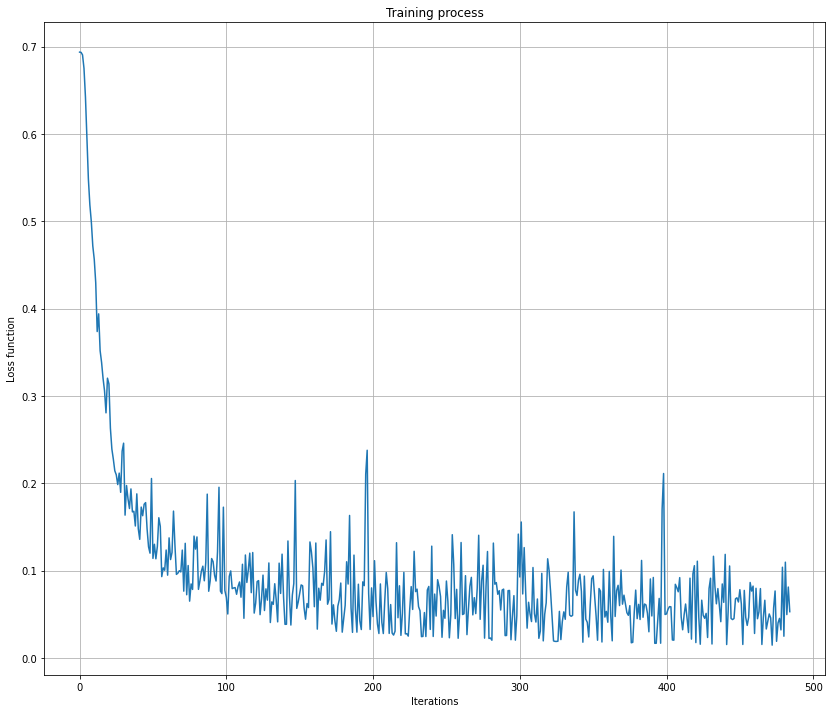

In [111]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

# Тестирование

А как это тестировать? Да, очень просто нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами

In [68]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
  
  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
  #расчет энтропии с усреднением по размеру бача
    
  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Проверим, что для каждого семплау нас есть предсказание

In [62]:
print(len(predicted), len(true_lbls))

2038 2038


Теперь применим стандартную Ф меру и оценим нашу модель

In [69]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.67


Сделайте тоже самое для своей модели...

In [100]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p1 = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
  h2 = p1.dot(w2) + b2
  p2 = 1/(1+np.exp(-h2))
  
  bce = (-np.sum(np.multiply(np.log(p2), y) + np.multiply((1 - y), np.log(1 - p2)))) / batch_size 
  #расчет энтропии с усреднением по размеру бача
    
  losses_test.append(bce)
  predicted.extend(p2)
  true_lbls.extend(y) 

In [101]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.97


# Немного торча

In [ ]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [ ]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

### Либо так

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [ ]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [ ]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [ ]:
model

In [ ]:
# можем посмотреть веса
model.linear_1.weight.shape

In [ ]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [ ]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

# Обучим нашу модель

In [ ]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [ ]:
# Одна эпоха прошла

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [ ]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# 
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
# 
model.eval()

In [ ]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [ ]:
pred.shape

In [ ]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [ ]:
pred.shape

In [ ]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [ ]:
y

In [ ]:
type(y)

In [ ]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [ ]:
# посчитаем метрику на батче
accuracy_score(y, pred)

In [ ]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [ ]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');